###### From SAV to LOVE

# HW 8

In [119]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, fmin, tpe, space_eval, Trials, STATUS_OK
from functools import partial

In [159]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [160]:
df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int64
RecordBeg            115155 non-null object
RecordEnd            59455 non-null object
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int64
HasKmLimit           115155 non-null int64
BonusMalus           115155 non-null int64
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int64
ClaimNbResp          115155 non-null float64
ClaimNbNonResp       115155 non-null float64
ClaimNbParking       115155 non-null float64
ClaimNbFireTheft     115155 non-null float64
ClaimNbWindscreen    115155 non-null float64
OutUseNb             115155 non-null float64
RiskArea             115155 non-null float64
dtypes

In [161]:
df['ClaimsCount'] = df.ClaimInd + df.ClaimNbResp + df.ClaimNbNonResp + df.ClaimNbParking + df.ClaimNbFireTheft + df.ClaimNbWindscreen
df.loc[df.ClaimAmount == 0, 'ClaimsCount'] = 0
df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", "ClaimNbWindscreen"], axis=1, inplace=True)

In [162]:
df.loc[(df.ClaimsCount == 11),'ClaimsCount'] = 10

In [163]:
ff = df.loc[(df.ClaimsCount == 10)|(df.ClaimsCount == 9)|(df.ClaimsCount == 8)|(df.ClaimsCount == 7),:] 
n = 10
for i in range(n):
  df = pd.concat([df,ff])
df.ClaimsCount.value_counts() 

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
5.0        441
7.0        286
6.0        128
8.0         66
9.0         22
10.0        11
Name: ClaimsCount, dtype: int64

In [164]:
ff = df.loc[(df.ClaimsCount == 6)|(df.ClaimsCount == 10)|(df.ClaimsCount == 9)|(df.ClaimsCount == 8),:] 
n = 5
for i in range(n):
  df = pd.concat([df,ff])
df.ClaimsCount.value_counts()  

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
6.0        768
5.0        441
8.0        396
7.0        286
9.0        132
10.0        66
Name: ClaimsCount, dtype: int64

In [61]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


x_train_cl, x_test_cl, y_train_cl, y_test_cl = train_test_split(df.iloc[-10000:,:2], df.ClaimsCount.values[-10000:] , test_size=0.3, random_state=1)
x_valid_cl, x_test_cl, y_valid_cl, y_test_cl = train_test_split(x_test_cl, y_test_cl, test_size=0.5, random_state=1)


In [190]:
x_train_cl.shape

(7000, 2)

In [191]:
y_train_cl.shape

(7000,)

In [62]:
train_cl = xgb.DMatrix(x_train_cl, y_train_cl)
valid_cl = xgb.DMatrix(x_valid_cl, y_valid_cl)
test_cl = xgb.DMatrix(x_test_cl, y_test_cl)

In [63]:
print(np.unique(train_cl.get_label()))
print(np.unique(test_cl.get_label()))
print(np.unique(valid_cl.get_label()))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [64]:
params_cl ={
            'max_depth': 3,  # глубина дерева
            'eta': 0.3,  # шаг обучения
            'num_class': 11,  # число классов
      
            'objective': 'multi:softmax',  # выход модели (фактически строим 11 моделей, но перевзвесили по софтмаксу)
            'silent':1 # молча, без логов 
            }

train_params_cl = {'num_boost_round': 300,

                'maximize': False,
                'verbose_eval': False}


progress_cl = dict()
xgb_cl = xgb.train(params=params_cl, dtrain=train_cl, early_stopping_rounds=10,
                     evals=[(train_cl, "train"), (valid_cl, "valid")])

[20:34:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.18814	valid-merror:0.18333
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 10 rounds.
[1]	train-merror:0.18057	valid-merror:0.17733
[2]	train-merror:0.17271	valid-merror:0.16933
[3]	train-merror:0.16657	valid-merror:0.16200
[4]	train-merror:0.16657	valid-merror:0.16200
[5]	train-merror:0.16700	valid-merror:0.16267
[6]	train-merror:0.16786	valid-merror:0.16133
[7]	train-merror:0.16914	valid-merror:0.16067
[8]	train-merror:0.16314	valid-merror:0.15267
[9]	train-merror:0.15629	valid-merror:0.14267


In [65]:
y_pred = xgb_cl.predict(xgb.DMatrix(df.iloc[:,:2])) 

accuracy = accuracy_score(df.ClaimsCount, y_pred) 
print(accuracy)

0.8736968449931413


In [15]:
y_pred

array([ 0.,  0.,  0., ...,  8.,  8., 10.], dtype=float32)

In [22]:
FreqCount = pd.DataFrame(y_pred, columns=['Count'])
FreqCount

,Count
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
116635,8.0
116636,9.0
116637,8.0
116638,8.0


In [31]:
FreqCount['Count'].value_counts()

0.0     113103
6.0       2187
8.0        713
9.0        421
10.0       214
7.0          2
Name: Count, dtype: int64

In [165]:
df.columns

Index(['Exposure', 'LicAge', 'RecordBeg', 'RecordEnd', 'Gender', 'MariStat',
       'SocioCateg', 'VehUsage', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'OutUseNb', 'RiskArea', 'ClaimsCount'],
      dtype='object')

In [166]:
df['weight'] = 1
df.loc[df['ClaimsCount'] == 0.0, 'weight'] = 0.05

In [ ]:
RecordBeg, RecordEnd, Gender, MariStat, SocioCateg, VehUsage

In [167]:
df_2 = df[['Exposure', 'LicAge', 'DrivAge', 'HasKmLimit', 'BonusMalus',
       'ClaimAmount', 'ClaimInd', 'OutUseNb', 'RiskArea', 'weight', 'ClaimsCount']]

In [150]:
df_2.loc[(df['ClaimsCount'] == 11),'ClaimsCount'] = 10

In [180]:
df['ClaimsCount'].value_counts()

0.0     103609
2.0       3725
1.0       3675
3.0       2402
4.0       1140
6.0        768
5.0        441
8.0        396
7.0        286
9.0        132
10.0        66
Name: ClaimsCount, dtype: int64

In [168]:
df_2.head()

,Exposure,LicAge,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,weight,ClaimsCount
0,0.083,332,46,0,50,0.0,0,0.0,9.0,0.05,0.0
1,0.916,333,46,0,50,0.0,0,0.0,9.0,0.05,0.0
2,0.550,173,32,0,68,0.0,0,0.0,7.0,0.05,0.0
3,0.089,364,52,0,50,0.0,0,0.0,8.0,0.05,0.0
4,0.233,426,57,0,50,0.0,0,0.0,7.0,0.05,0.0


In [206]:
x_train, x_test, y_train, y_test = train_test_split(df_2.iloc[-10000:,:10], df_2.ClaimsCount.values[-10000:] , test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

In [207]:
x_train.shape

(7000, 10)

In [208]:
y_train.shape

(7000,)

In [209]:
train_cl = xgb.DMatrix(x_train, y_train, weight=x_train['weight'])
valid_cl = xgb.DMatrix(x_valid, y_valid)
test_cl = xgb.DMatrix(x_test, y_test)

In [172]:
# Зададим функцию Deviance для распределения Пуассона

def xgb_eval_dev_poisson(yhat, y):
    t_hat, t = yhat + 1, y.get_label() + 1
    return 'dev_poisson', 2 * np.sum(t * np.log(t / t_hat) - (t - t_hat))

In [173]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    return {'loss': score, 'status': STATUS_OK}

In [192]:
# Определим параметры выполнения кроссвалидации

cv_params = {'num_boost_round': 300,
             'nfold': 5,
             'shuffle': True,
             'stratified': False,
             'maximize': False,
             'early_stopping_rounds': 20
              }

In [193]:
# Определим границы, в которых будем искать гиперпараметры

space_freq = {'objective': 'multi:softmax',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'num_class': 11,  # число классов
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

In [195]:
# Оптимизация (количество итераций снижено для ускорения работы)

trials = Trials()
best = fmin(fn=partial(objective, cv_params=cv_params, data=train_cl),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=20, timeout=3600)

100%|█████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.76s/trial, best loss: 0.1869278]


In [196]:
# Оптимальные гиперпараметры 

best_params = space_eval(space_freq, best)
best_params

{'alpha': 0.6301543217440518,
 'colsample_bytree': 0.5904327633173406,
 'eta': 0.7885919544412047,
 'lambda': 0.920323377435739,
 'max_depth': 10,
 'min_child_weight': 0.3992934415860072,
 'num_class': 11,
 'objective': 'multi:softmax',
 'subsample': 0.9456841699894425,
 'tree_method': 'hist'}

In [200]:
train_params = {'num_boost_round': 300,
                'maximize': False,
                'verbose_eval': False}

In [210]:
# Построение модели с ранней остановкой (early stopping)

progress = dict()
xgb_freq = xgb.train(params=best_params, dtrain=train_cl, early_stopping_rounds=10,
                     evals=[(train_cl, "train"), (valid_cl, "valid")],
                     evals_result=progress, **train_params)

In [211]:
xgb_freq.best_score

0.038

In [212]:
# Построение модели без ранней остановки

progress_wo_es = dict()
xgb_freq_wo_es = xgb.train(params=best_params, dtrain=train_cl, evals=[(train_cl, "train"), (valid_cl, "valid"), (test_cl, "test")],
                           evals_result=progress_wo_es, **train_params)

In [214]:
y_test_f = xgb_freq_wo_es.predict(test_cl)
y_valid_f = xgb_freq_wo_es.predict(valid_cl)
y_train_f = xgb_freq_wo_es.predict(train_cl)

In [216]:
f1_score(y_test, y_test_f, average='micro')

0.9606666666666668

In [223]:
f1_score(y_train, y_train_f, average='micro')

1.0

In [224]:
f1_score(y_valid, y_valid_f, average='micro')

0.962

In [219]:
dfsets = [{'set': 'train', 'dmat': train_cl, 'target': y_train},
          {'set': 'valid', 'dmat': valid_cl, 'target': y_valid},
          {'set': 'test', 'dmat': test_cl, 'target': y_test}]

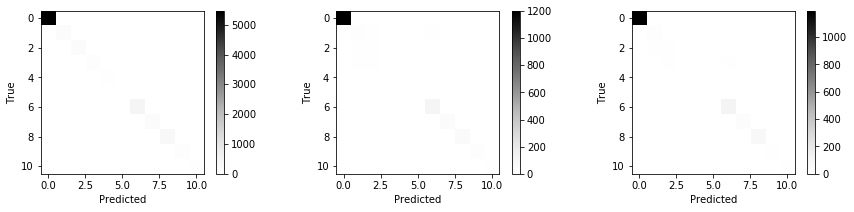

In [221]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_freq_wo_es.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()